In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import tqdm

# Data Overview

There are 4 relevant files:
- train.csv contains the IDs and whether users have churned or not
- transactions.csv contains details like payment method or whether a subscription was cancelled (which is not necessarily churn?)
- user_logs.csv (30GB) contains the (daily) listening behaviour of a user in terms of number of songs played
- members.csv contains the user's age, city and more membership information

# Data Description

In [3]:
# Load the datasets
train = pd.read_csv('./data/kkbox/train.csv')
user_logs = pd.read_csv('./data/kkbox/user_logs.csv', nrows=10**6) # only load the first 25mn rows (~10%)
transactions = pd.read_csv('./data/kkbox/transactions.csv')
members = pd.read_csv('./data/kkbox/members_v3.csv')

In [4]:
# Get Info for the datasets
print(train.info())
print(user_logs.info())
print(transactions.info())
print(members.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992931 entries, 0 to 992930
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   msno      992931 non-null  object
 1   is_churn  992931 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   msno        1000000 non-null  object 
 1   date        1000000 non-null  int64  
 2   num_25      1000000 non-null  int64  
 3   num_50      1000000 non-null  int64  
 4   num_75      1000000 non-null  int64  
 5   num_985     1000000 non-null  int64  
 6   num_100     1000000 non-null  int64  
 7   num_unq     1000000 non-null  int64  
 8   total_secs  1000000 non-null  float64
dtypes: float64(1), int64(7), object(1)
memory usage: 68.7+ MB
None
<class 'pandas.core.frame.

In [5]:
# Get an overview of the datasets
print(f"Train: \n{train.describe()} \n")
print(train.head())
print(f"Unique values: {len(train['msno'].unique())}")
print(f"NA values: \n{(train.isna().sum())}")

Train: 
            is_churn
count  992931.000000
mean        0.063923
std         0.244616
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000 

                                           msno  is_churn
0  waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=         1
1  QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=         1
2  fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=         1
3  mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=         1
4  XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=         1
Unique values: 992931
NA values: 
msno        0
is_churn    0
dtype: int64


Observations: 
- The ID column is msno, which contains long character strings
- There are 992,931 unique observations in the training data, of which only 6.3% actually are churners
- The definition of churn is: "no new valid service subscription within 30 days after the current membership expires."
- There are no NA values in the dataset

In [6]:
# Get an overview of the datasets
print(f"User logs (subset): \n {user_logs.describe()} \n")
print(user_logs.head(15))
print(f"Unique values: {len(user_logs['msno'].unique())}")
print(f"NA values: \n{(user_logs.isna().sum())}")

User logs (subset): 
                date          num_25          num_50          num_75  \
count  1.000000e+06  1000000.000000  1000000.000000  1000000.000000   
mean   2.015737e+07        6.513753        1.645647        1.018495   
std    6.180546e+03       13.896784        4.253038        2.182010   
min    2.015010e+07        0.000000        0.000000        0.000000   
25%    2.015082e+07        0.000000        0.000000        0.000000   
50%    2.016031e+07        2.000000        1.000000        0.000000   
75%    2.016091e+07        7.000000        2.000000        1.000000   
max    2.017023e+07     1377.000000      494.000000      470.000000   

              num_985         num_100         num_unq    total_secs  
count  1000000.000000  1000000.000000  1000000.000000  1.000000e+06  
mean         1.130756       30.695660       30.100037 -1.623313e+12  
std          3.051005       41.306784       33.752520  1.223512e+14  
min          0.000000        0.000000        1.000000 -9.2

Observations:
- The subset contains the first 20mn (out of ca. 4-5bn) rows of the user_logs dataset
- In 20mn rows, there are 1.72mn unique IDs and no NA values
- The dates in the dataset span between early 2015 and early 2017
- The integer features num_25, num_50, num_75, num_985, and num_100 tell us the number of songs for this day that the user played for <25%, 25-50%, 50-75%, 75-98.5%, or >98.5% of their total duration.
- num_unq describes the number of unique songs a user listened to for the day. The median is 19, the mean 30 and the max is 2767. The minimum of 1 tells us that data is only recorded if at least one song is listened to
- total_sec describes the total number of seconds of music played per user per day. This data contains some spurious entries with negative and highly positive values 

In [7]:
# Get an overview of the datasets
print(f"Transactions: \n {transactions.describe()} \n")
print(transactions.head(15))
print(f"Unique values: {len(transactions['msno'].unique())}")
print(f"NA values: \n{(transactions.isna().sum())}")

Transactions: 
        payment_method_id  payment_plan_days  plan_list_price  \
count       2.154775e+07       2.154775e+07     2.154775e+07   
mean        3.893310e+01       3.133906e+01     1.398850e+02   
std         3.507936e+00       3.035649e+01     1.309647e+02   
min         1.000000e+00       0.000000e+00     0.000000e+00   
25%         3.800000e+01       3.000000e+01     9.900000e+01   
50%         4.100000e+01       3.000000e+01     1.490000e+02   
75%         4.100000e+01       3.000000e+01     1.490000e+02   
max         4.100000e+01       4.500000e+02     2.000000e+03   

       actual_amount_paid  is_auto_renew  transaction_date  \
count        2.154775e+07   2.154775e+07      2.154775e+07   
mean         1.419873e+02   8.519661e-01      2.015760e+07   
std          1.324824e+02   3.551336e-01      6.155979e+03   
min          0.000000e+00   0.000000e+00      2.015010e+07   
25%          9.900000e+01   1.000000e+00      2.015091e+07   
50%          1.490000e+02   1.00000

In [8]:
print(f"Erroneous expiry dates:")
print(transactions[transactions['membership_expire_date'] < 20150101])

print(transactions[transactions['membership_expire_date'] < transactions['transaction_date'] - 90])

Erroneous expiry dates:
                                                  msno  payment_method_id  \
2147      feoqKszFUCDjm6c4nsByAWO4h85yLoOj0iNHW573mM8=                 17   
4665      ZaAH3Flb1vP6gmfZzocI0y3B9mHi6fgqZwbdmGsUzZU=                 41   
7688      W27NhBZTYj1B/InWGtogntbg2gcQokhKF8ZVQrbikIY=                 17   
10053     D41RL9XWBy93GNqsTJYt8Pz9OqzwRV+q99l7qdIuOBc=                 41   
14537     JKYCnPHexLxDsd4u+dCzP6UXWOAC7oiuAwFSSKGXnVM=                 41   
...                                                ...                ...   
21533491  nJgMDpe15euogV2UsNHf7PqjmbHQY0/uTddHjko4fDo=                 41   
21533725  0t5DcE4E/AwT5ylSgVYGfUZJt6+1PTV2f/iGYwi9S0A=                 41   
21540309  DNbcJ2sTrfvJy64KRaRsYKF0Tm3qgSEMmq5GlkOka/c=                 41   
21540409  99Evy3X4xqtLIZRG4ZeanMRmRLm2lm1FbmOqjdRrhLw=                 41   
21542913  CTNuDWh1uJlNUqkUH8l6FKWDx54e84fS6q8mjLG9oXc=                 41   

          payment_plan_days  plan_list_price  actua

Observations:
- There are 21.5mn observations with 2.36mn unique IDs (vs. 993k unique IDs in train) and no NA values
- payment_method_id is encoded in integers from 1 to 41
- payment_plan_days measures the length of membership subscription in days. Values are between 0 and 450, with most subscriptions lasting only 30 days (median)
- plan_list_price describes the (theoretical) price of the plan in NTD (New Taiwan Dollar)
- actual_amount_paid describes the actual paid amount in NTD for the subscription
- is_auto_renew is a binary value, with a value of 1 85% of the time
- transaction_date and membership_expire_date are date values between early 01/01/2015 and 31/03/2017
- The definition of churn is: "no new valid service subscription within 30 days after the current membership expires."
- is_cancel indicates a user cancellation in the transaction, which can mean churn or a new (different) subscription plan
- There are transactions with erroneous expiry dates (i.e. the expiry date is before the transaction date)

In [9]:
# Get an overview of the datasets
print(f"Transactions: \n {members.describe()} \n")
print(members.head(15))
print(f"Unique values: {len(members['msno'].unique())}")
print(f"NA values: \n{(members.isna().sum())}")

Transactions: 
                city            bd  registered_via  registration_init_time
count  6.769473e+06  6.769473e+06    6.769473e+06            6.769473e+06
mean   3.847358e+00  9.795794e+00    5.253069e+00            2.014518e+07
std    5.478359e+00  1.792590e+01    2.361398e+00            2.318601e+04
min    1.000000e+00 -7.168000e+03   -1.000000e+00            2.004033e+07
25%    1.000000e+00  0.000000e+00    4.000000e+00            2.014042e+07
50%    1.000000e+00  0.000000e+00    4.000000e+00            2.015101e+07
75%    4.000000e+00  2.100000e+01    7.000000e+00            2.016060e+07
max    2.200000e+01  2.016000e+03    1.900000e+01            2.017043e+07 

                                            msno  city  bd  gender  \
0   Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=     1   0     NaN   
1   +tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=     1   0     NaN   
2   cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=     1   0     NaN   
3   9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnR

Observations:
- there are 6.7mn records for 6.7mn unique members (vs. 993k unique IDs in train) 
- city encodes 21 different cities as integers (there is no city 2)
- bd describes the age of a member and contains clear outliers (negative and highly positive values)
- gender is a character string (male/ female), containing 4.4mn NaN values
- registered_via is the registration method encoded as an integer (-1 to 19)
- registration_init_time is the registration date

# Data Cleaning

train data
- no outlier cleaning

user_logs data
- date as datetime column
- num_unq outliers
- total_secs outliers

transactions data
- transaction_date as datetime
- membership_expire_date as datetime
- remove obeservations with membership_expiry_date < 01/01/2015

members data
- bd renaming & outliers
- replace NA values in gender
- registration_init_time as datetime

In [10]:
# User_logs Data
# Convert date column to datetime
user_logs['date'] = pd.to_datetime(user_logs['date'].astype('str'), format='%Y%m%d')

# Handle total_secs Outliers
# since negative listening time is not possible, any entrys with less or equal to 0s can be dropped
# since there are maximum 86400 seconds in a day, any entrys with more than 86400 seconds can be dropped
#print(len(user_logs[user_logs['total_secs'] <= 0]) / len(user_logs))
#print(len(user_logs[user_logs['total_secs']>86400]) / len(user_logs)) 
# dropping rows has almost no impact on data quantity
user_logs = user_logs[(user_logs['total_secs'] >= 0) & (user_logs['total_secs'] <= 86400)]

# Handle num_unq Outliers
#print(len(user_logs[user_logs['num_unq']>1000]))
#user_logs[user_logs['num_unq']>1000]['num_unq'].hist()
#plt.show()
#print(user_logs[user_logs['num_unq']>1000])

# rows with over 1000 unique songs player usually play songs for <25% of the song's duration, which makes the values possible. There is no reason to drop these rows


In [11]:
# Transactions Data
# Convert transaction_date column to datetime
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'].astype('str'), format='%Y%m%d')
transactions['membership_expire_date'] = pd.to_datetime(transactions['membership_expire_date'].astype('str'), format='%Y%m%d')
transactions = transactions[transactions['membership_expire_date'] >= datetime(year=2015, month=1, day=1)]

# Drop duplicate rows
transactions = transactions.drop_duplicates()

In [12]:
# Members Data
# bd renamed as age 
members = members.rename(columns={'bd': 'age'})

# visualizing age outliers
#members[(members['age'] >= 0) & (members['age'] < 99)]['age'].hist(bins=25)
#plt.title("Recorded age of members")
#plt.show()

#print((len(members[members['age'] < 0]) + len(members[members['age'] > 99])) / len(members))
# members with ages outside of 0-99 can be dropped
members = members[(members['age'] >= 0) & (members['age'] < 99)]
#len(members[members['age'] == 0])
# 4.5mn members (out of 6.7mn total) have age 0 (i.e. using the current date as their birthday), they can not be dropped

# replace NAs in gender
members['gender'] = members['gender'].fillna('not_specified')

# registration_init_time as datetime
members['registration_init_time'] = pd.to_datetime(members['registration_init_time'].astype('str'), format='%Y%m%d')


# Univariate Analysis
I consider only the data that labels exist for (by merging datasets with the train dataset).

In [13]:
# Merging Datasets and Setting dTypes Correctly
# Members dataset
members = pd.merge(train, members, how='left', on='msno') # leaves NA values
members = members.dropna(axis=0)
members[['age', 'city', 'registered_via']] = members[['age', 'city', 'registered_via']].astype('int64')

# Transactions dataset
transactions = pd.merge(train, transactions, how='left', on='msno') # no NA values

# User Logs dataset
#user_logs = pd.merge(train, user_logs, how='left', on='msno') # NA values since not using full user_logs dataset
#user_logs = user_logs.dropna(axis=0)

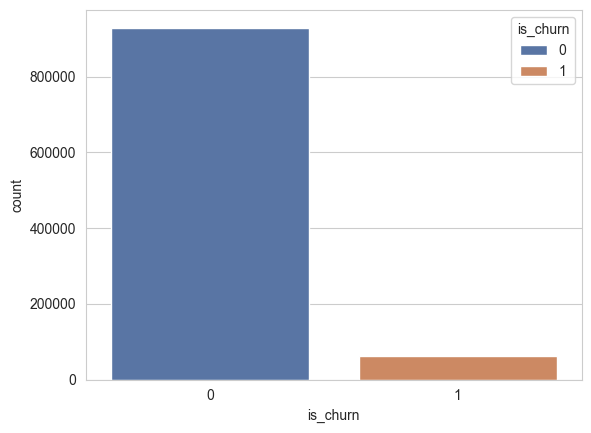

0.06392287077349786


In [14]:
# Train Dataset
sns.countplot(data=train, x="is_churn", hue='is_churn', palette='deep')
plt.show()
print(train['is_churn'].mean())

Only 6.4% of users actually churn. 

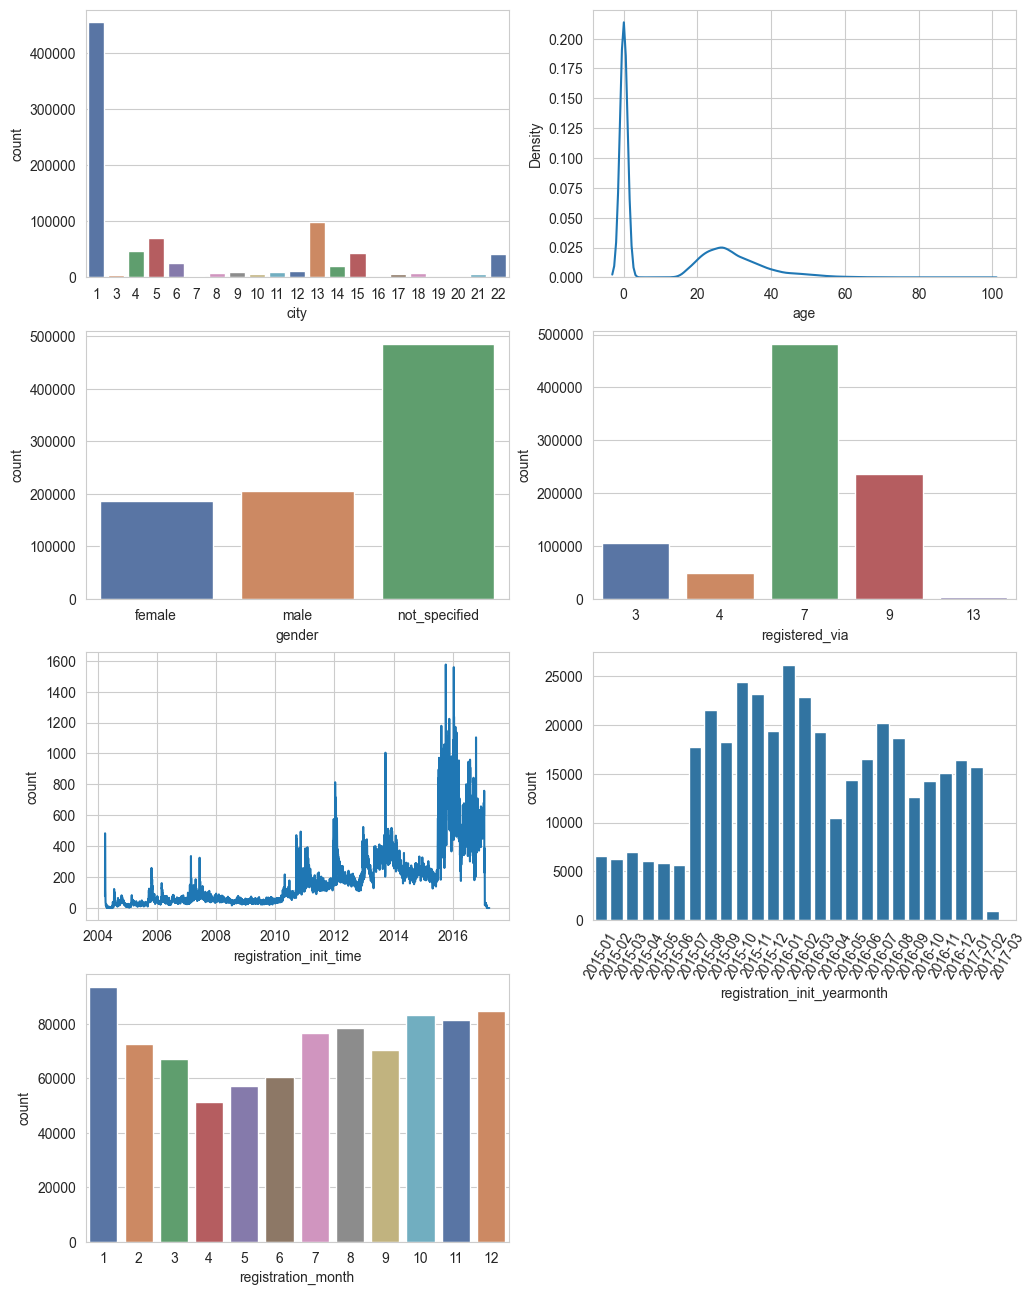

In [15]:
# Members Dataset
# Registration City
plt.figure(figsize=(12,16))
plt.subplot(4, 2, 1)
sns.countplot(data=members, x='city', hue='city', palette='deep', legend=False)

# Registration Age
plt.subplot(4, 2, 2)
sns.kdeplot(data=members, x='age', legend=False)
#plt.yscale('log')
#plt.ylabel('log_count')

# Gender
plt.subplot(4, 2, 3)
sns.countplot(data=members, x='gender', hue='gender', palette='deep', legend=False)

# Registered Via
plt.subplot(4, 2, 4)
sns.countplot(data=members, x='registered_via', hue='registered_via', palette='deep', legend=False)

# First Registration 
plt.subplot(4, 2, 5)
sns.lineplot(data=members['registration_init_time'].value_counts().reset_index(), x='registration_init_time', y='count', legend=False)

plt.subplot(4, 2, 6)
members['registration_init_yearmonth'] = members['registration_init_time'].dt.to_period('M')
sns.countplot(data=members[members['registration_init_time'] > datetime(year=2015, month=1, day=1)], 
              x='registration_init_yearmonth', 
              legend=False)
plt.xticks(rotation=60)

# Registration by Months
members['registration_month'] = members['registration_init_time'].dt.month
plt.subplot(4, 2, 7)
sns.countplot(data=members, x='registration_month', hue='registration_month', palette='deep', legend=False)


plt.show()

Observations
- there are 21 cities (no city 2). Most users are from city 1, with city 13 in a distant second place
- Most users have not provided a real age (most used value is 0). After that the distribution is skewed towards people in their 20s & 30s but ranges from 0 to 100. 
- more than half of the users have not specified their gender, of the ones that have slightly more than half are male
- There are 5 registration methods, with over half of the users registering via method 7 and almost none using method 13
- Initial registration of users ranges between 2004 and 2017, with several peaks in early years and an upward trend from 2010 onwards. Most registrations occurred between mid-2015 and late 2016
- Registration by month is relatively balanced although most users register in January or near the end of the year. The least users register in April.  

In [ ]:
# Transactions Dataset
plt.figure(figsize=(12,21))

# Payment Method
plt.subplot(7,1,1)
sns.countplot(data=transactions, x='payment_method_id', hue='payment_method_id', palette='deep',legend=False)
plt.yscale('log')
plt.ylabel('log_count')

# Subscription Duration (days)
plt.subplot(7,1,2)
sns.countplot(data=transactions, x='payment_plan_days', hue='payment_plan_days', palette='deep', legend=False)
plt.yscale('log')
plt.ylabel('log_count')

# Theoretical Payment
plt.subplot(7,1,3)
sns.countplot(data=transactions, x='plan_list_price', hue='plan_list_price', palette='deep', legend=False)
plt.yscale('log')
plt.ylabel('log_count')

# Actual Payment
plt.subplot(7,1,4)
sns.countplot(data=transactions, x='actual_amount_paid', hue='actual_amount_paid', palette='deep', legend=False)
plt.yscale('log')
plt.ylabel('log_count')

# Difference in Payment
transactions['payment_diff'] = transactions['plan_list_price'] - transactions['actual_amount_paid']
plt.subplot(7,1,5)
sns.countplot(data=transactions, x='payment_diff', hue='payment_diff', palette='deep', legend=False)
plt.yscale('log')
plt.ylabel('log_count')

# Auto-Renewing
plt.subplot(7, 2, 11)
sns.countplot(data=transactions, x='is_auto_renew', hue='is_auto_renew', palette='deep', legend=False)

# Cancellation
plt.subplot(7, 2, 12)
sns.countplot(data=transactions, x='is_cancel', hue='is_cancel', palette='deep', legend=False)

# Transaction dates and Membership expiry dates
plt.subplot(7, 1, 7)
members_expiry_dates = transactions['membership_expire_date'].value_counts().reset_index()
transaction_dates = transactions['transaction_date'].value_counts().reset_index()
merged_dates = pd.merge(members_expiry_dates, transaction_dates, how='outer', left_on='membership_expire_date', right_on='transaction_date')
merged_dates = merged_dates.fillna(value=0)
merged_dates['date'] = merged_dates['membership_expire_date']
merged_dates = merged_dates.drop(['membership_expire_date', 'transaction_date'], axis=1)
merged_dates[['membership_expiry_date', 'transaction_date']] = merged_dates[['count_x', 'count_y']].astype('int64')
merged_dates = pd.melt(merged_dates, id_vars=['date'], 
                       value_vars=['membership_expiry_date', 'transaction_date'], 
                       value_name='count', var_name='type')
sns.lineplot(data=merged_dates, x='date', y='count', hue='type', palette='deep', legend=True, alpha=0.7)

plt.show()


transactions.info()

Observations (note log scales on some plots):
- most used payment method is 41
- most common subscription durations are 30, 0, 31, 7 days (monthly and short-term trial subscriptions)
- Theoretical prices vary, with the most-used values being 149, 99, 0, 129. They range up to 2000 NTD.
- Actual prices also vary, though most values follow the theoretical prices. They also range up to 2000 NTD. 
- Difference (theoretical - actual) between theoretical and actual prices is 0 in most cases, followed by -149 (users cancelling?), 30 (discount?) and 149 (free users switching to subscription?) 
- Most users use the auto-renew feature
- very few memberships are cancelled
- membership expiries and transaction dates (auto)correlate strongly, mostly around the beginning of the month (auto-renewals?)
- transaction dates are a lot more common than expiries indicating that there may be monthly payments for yearly subscriptions

In [ ]:
# User Logs Dataset
plt.figure(figsize=(12,8))

# Entries per user
plt.subplot(2,2,1)
user_logs['msno'].value_counts().hist()
plt.ylabel('Count')
plt.xlabel('Entries per User')

# Listening Time
plt.subplot(2,2,2)
listening_time = user_logs.groupby('msno').agg({'total_secs': 'sum'}).reset_index()
#print(listeing_time.info()) # min < 1, median = 92156, max = 4.8mn
listening_time = listening_time[listening_time['total_secs'] < 1*10**6]
sns.boxplot(data=listening_time, x='total_secs', legend=True)

# # Daily Unique Song Count
# plt.subplot(2,2,3)
# sns.histplot(data=user_logs[user_logs['num_unq']<500], x='num_unq')
# plt.yscale('log')
# plt.ylabel('log_count')
# plt.xlabel('Unique Songs ')

# Average Daily Unique Song Count per User
plt.subplot(2,2,3)
user_song_counts = user_logs.groupby('msno').agg({'num_unq': 'mean'}).reset_index()
#print(user_song_counts.describe()) # min = 1, mean = 26.4, median = 21.5, max = 809
sns.kdeplot(data=user_song_counts[user_song_counts['num_unq']>0], x='num_unq')
plt.xlabel('Mean Unique Daily Songs per User')

# Average Song Listening Behaviour
listening_behavior = user_logs.groupby('msno').agg({'num_25': 'mean', 'num_50': 'mean', 'num_75': 'mean', 
                                                    'num_985': 'mean', 'num_100': 'mean'})




plt.show()

In [ ]:
user_logs.info()

In [ ]:
listening_behavior = user_logs.groupby('msno').agg({'num_25': 'mean', 'num_50': 'mean', 'num_75': 'mean', 
                                                    'num_985': 'mean', 'num_100': 'mean'}).reset_index()
listening_behavior.info()

In [ ]:
listening_behavior = listening_behavior.melt(id_vars=['msno'], value_vars=['num_25', 'num_50', 'num_75', 'num_985', 'num_100'], var_name='%_played', value_name='value')
listening_behavior.head()

In [ ]:
sns.histplot(data=listening_behavior[listening_behavior['value']<100], x='value', hue='%_played', palette='deep', legend=True, alpha=0.7)
plt.ylim((0,15*10**3))
plt.show()

In [ ]:
listening_behavior[listening_behavior['%_played'] == 'num_25']['value'].max()

# Feature Engineering 
Feature Engineering for Transactions Data
Feature Engineering for Users Data

In [ ]:
## Feature Engineering for Transactions Data

# Create Columns for 
# - total number of transactions
# - total actual payment
# - mean payment per transaction
# - mean payment plan days
# - mean payment diff
# - last payment diff
# - mean is_auto_renew
# - last is_auto_renew
# - mean is_cancel
# - last is_cancel

def num_transactions(df):
    return df['msno'].count()

def total_act_pay(df):
    return df['actual_amount_paid'].sum()

def mean_act_pay(df):
    return df['actual_amount_paid'].mean()

def mean_plan_days(df):
    return df['payment_plan_days'].mean()

def mean_pay_diff(df):
    return df['payment_diff'].mean()

def last_pay_diff(df):
    return df[(df['transaction_date'] >= max(df['transaction_date'])) & (df['membership_expire_date'] >= max(df['membership_expire_date']))]['payment_diff'].mean()

def mean_auto_renew(df):
    return df['is_auto_renew'].mean()

def last_auto_renew(df):
    return df[(df['transaction_date'] >= max(df['transaction_date'])) & (df['membership_expire_date'] >= max(df['membership_expire_date']))]['is_auto_renew'].mean()

def mean_cancel(df):
    return df['is_cancel'].mean()

def last_cancel(df):
    return df[(df['transaction_date'] >= max(df['transaction_date'])) & (df['membership_expire_date'] >= max(df['membership_expire_date']))]['is_cancel'].mean()



# list of functions
func_list = [num_transactions, total_act_pay, mean_act_pay, mean_plan_days, mean_pay_diff, last_pay_diff, mean_auto_renew, last_auto_renew, mean_cancel, last_cancel]

# # group dataset and create result df
# grouped = transactions.groupby('msno')[transactions.columns]
# transaction_features = pd.DataFrame({'msno': transactions['msno'].unique()})
# 
# # apply functions
# for func in tqdm.tqdm(func_list):
#     intermediate = grouped.apply(func).reset_index(name=str(func.__name__))
#     transaction_features = pd.merge(transaction_features, intermediate, on='msno', how='inner')
#     
# transaction_features.to_csv('./data/kkbox/transactions_features')

In [4]:
## Feature Engineering for Users Data

# Create columns for 
# - number of songs and total seconds listened in the last recorded 1, 2, 3, 6, 9, 12 months + all time
# - average num_25, num_50, num_75, num_985, num_100
# - average num_25/num_unq, num_50/num_unq, num_75/num_unq, num_985/num_unq, num_100/num_unq
# - average seconds per song (total_secs/ (num_25+num_50+num_75+num_985+num_100)
# - difference in listening time in the last 1, 2, 3, 6, 9, 12 months

# number of songs listened to in the last 90, 180, 270, 365 days, all time
def last_90days_avg_num_unq(df):
    return df[(df['date'] > df['date'].max() - timedelta(days=90))]['num_unq'].mean()

def last_180days_avg_num_unq(df):
    return df[(df['date'] > df['date'].max() - timedelta(days=180))]['num_unq'].mean()

def last_270days_avg_num_unq(df):
    return df[(df['date'] > df['date'].max() - timedelta(days=270))]['num_unq'].mean()

def last_365days_avg_num_unq(df):
    return df[(df['date'] > df['date'].max() - timedelta(days=365))]['num_unq'].mean()

def all_time_avg_num_unq(df):
    return df['num_unq'].mean()

# total seconds listened in the last 30, 60, 90, 180, 270, 365 days, all time
def last_30days_total_secs(df):
    return df[(df['date'] > df['date'].max() - timedelta(days=30))]['total_secs'].sum()

def last_60days_total_secs(df):
    return df[(df['date'] > df['date'].max() - timedelta(days=60))]['total_secs'].sum()

def last_90days_total_secs(df):
    return df[(df['date'] > df['date'].max() - timedelta(days=90))]['total_secs'].sum()

def last_180days_total_secs(df):
    return df[(df['date'] > df['date'].max() - timedelta(days=180))]['total_secs'].sum()

def last_270days_total_secs(df):
    return df[(df['date'] > df['date'].max() - timedelta(days=270))]['total_secs'].sum()

def last_365days_total_secs(df):
    return df[(df['date'] > df['date'].max() - timedelta(days=365))]['total_secs'].mean()

def all_time_total_secs(df):
    return df['total_secs'].sum()

# average num_25, num_50, num_75, num_985, num_100
def avg_num_25(df):
    return df['num_25'].mean()

def avg_num_50(df):
    return df['num_50'].mean()

def avg_num_75(df):
    return df['num_75'].mean()

def avg_num_985(df):
    return df['num_985'].mean()

def avg_num_100(df):
    return df['num_100'].mean()

# average num_25/num_unq, num_50/num_unq, num_75/num_unq, num_985/num_unq, num_100/num_unq
def avg_num25_per_num_unq(df):
    return df['num_25'].sum()/df['num_unq'].sum()

def avg_num50_per_num_unq(df):
    return df['num_50'].sum()/df['num_unq'].sum()

def avg_num75_per_num_unq(df):
    return df['num_75'].sum()/df['num_unq'].sum()

def avg_num985_per_num_unq(df):
    return df['num_985'].sum()/df['num_unq'].sum()

def avg_num100_per_num_unq(df):
    return df['num_100'].sum()/df['num_unq'].sum()

# average seconds per song in the last 90, 180, 270, 365 days, all time
def last_90_avg_sec_per_song(df):
    return df[(df['date'] > df['date'].max() - timedelta(days=90))]['total_secs'].sum() / df[(df['date'] > df['date'].max() - timedelta(days=90))][['num_25', 'num_50', 'num_75', 'num_985', 'num_100']].sum().sum()

def last_180_avg_sec_per_song(df):
    return df[(df['date'] > df['date'].max() - timedelta(days=180))]['total_secs'].sum() / df[(df['date'] > df['date'].max() - timedelta(days=180))][['num_25', 'num_50', 'num_75', 'num_985', 'num_100']].sum().sum()

def last_270_avg_sec_per_song(df):
    return df[(df['date'] > df['date'].max() - timedelta(days=270))]['total_secs'].sum() / df[(df['date'] > df['date'].max() - timedelta(days=270))][['num_25', 'num_50', 'num_75', 'num_985', 'num_100']].sum().sum()

def last_365_avg_sec_per_song(df):
    return df[(df['date'] > df['date'].max() - timedelta(days=365))]['total_secs'].sum() / df[(df['date'] > df['date'].max() - timedelta(days=365))][['num_25', 'num_50', 'num_75', 'num_985', 'num_100']].sum().sum()

def all_time_avg_sec_per_song(df):
    return df['total_secs'].sum() / df[['num_25', 'num_50', 'num_75', 'num_985', 'num_100']].sum().sum()

# apply all functions in one go
func_list = [last_90days_avg_num_unq, last_180days_avg_num_unq, last_270days_avg_num_unq, last_365days_avg_num_unq, 
             all_time_avg_num_unq,
             last_30days_total_secs, last_60days_total_secs, last_90days_total_secs, last_180days_total_secs,
             last_270days_total_secs, last_365days_total_secs, all_time_total_secs,
             avg_num_25, avg_num_50, avg_num_75, avg_num_985, avg_num_100,
             avg_num25_per_num_unq, avg_num50_per_num_unq, avg_num75_per_num_unq, avg_num985_per_num_unq, 
             avg_num100_per_num_unq,
             last_90_avg_sec_per_song, last_180_avg_sec_per_song, last_270_avg_sec_per_song, last_365_avg_sec_per_song, 
             all_time_avg_sec_per_song]

# grouped = user_logs.groupby('msno')[user_logs.columns]
# result = pd.DataFrame({'msno': user_logs['msno'].unique()})
# for func in tqdm.tqdm(func_list):
#     intermediate = grouped.apply(func).reset_index(name=str(func.__name__))
#     result = pd.merge(result, intermediate, on='msno', how='inner')
#     
# result.to_csv('./data/kkbox/user_logs_features')

In [5]:
# Additional Feature Engineering for Users Dataset
func_list = [last_30days_total_secs, last_60days_total_secs]

# apply new features
grouped = user_logs.groupby('msno')[user_logs.columns]
result = pd.DataFrame({'msno': user_logs['msno'].unique()})
for func in tqdm.tqdm(func_list):
    intermediate = grouped.apply(func).reset_index(name=str(func.__name__))
    result = pd.merge(result, intermediate, on='msno', how='inner')
    
# load features data frame
user_logs_features = pd.read_csv('./data/kkbox/user_logs_features', index_col=0)

# merge user_logs_features with new features
user_logs_features = pd.merge(user_logs_features, result, on='msno', how='inner')


100%|██████████| 2/2 [36:38<00:00, 1099.09s/it]


In [8]:
user_logs_features.to_csv('./data/kkbox/user_logs_features2')

In [7]:
# Additional Feature Engineering for Users Dataset
# difference in listening time in the last 1, 2, 3, 6, 9, 12 months

# difference total seconds in the last 30 days vs. (30day) average total seconds last 60 days
user_logs_features['total_secs_diff_last_30_vs_last_60_avg'] = (user_logs_features['last_30days_total_secs'] - (user_logs_features['last_60days_total_secs'] / 2)) / (user_logs_features['last_60days_total_secs'] / 2)

# difference total seconds in the last 30 days vs. (30day) average total seconds last 90 days
user_logs_features['total_secs_diff_last_30_vs_last_90_avg'] = (user_logs_features['last_30days_total_secs'] - (user_logs_features['last_90days_total_secs'] / 3)) / (user_logs_features['last_90days_total_secs'] / 3)

# total seconds in the last 30 days vs. (30day) average total seconds last 180 days
user_logs_features['total_secs_diff_last_30_vs_last_180_avg'] = (user_logs_features['last_30days_total_secs'] - (user_logs_features['last_180days_total_secs'] / 6)) / (user_logs_features['last_180days_total_secs'] / 6)

# total seconds in the last 60 days vs. (30day) average total seconds last 180 days
user_logs_features['total_secs_diff_last_60_vs_last_180_avg'] = ((user_logs_features['last_60days_total_secs'] / 2) - (user_logs_features['last_180days_total_secs'] / 6)) / (user_logs_features['last_180days_total_secs'] / 6)

# total seconds in the last 60 days vs. (30day) average total seconds last 270 days
user_logs_features['total_secs_diff_last_60_vs_last_270_avg'] = ((user_logs_features['last_60days_total_secs'] / 2) - (user_logs_features['last_270days_total_secs'] / 9)) / (user_logs_features['last_270days_total_secs'] / 9)

# total seconds in the last 60 days vs. (30day) average total seconds last 365 days
user_logs_features['total_secs_diff_last_60_vs_last_365_avg'] = ((user_logs_features['last_60days_total_secs'] / 2) - (user_logs_features['last_365days_total_secs'] / 12)) / (user_logs_features['last_365days_total_secs'] / 12)

# total seconds in the last 90 days vs. (30day) average total seconds last 180 days
user_logs_features['total_secs_diff_last_90_vs_last_180_avg'] = ((user_logs_features['last_60days_total_secs'] / 3) - (user_logs_features['last_180days_total_secs'] / 6)) / (user_logs_features['last_180days_total_secs'] / 6)

# total seconds in the last 90 days vs. (30day) average total seconds last 270 days
user_logs_features['total_secs_diff_last_90_vs_last_270_avg'] = ((user_logs_features['last_60days_total_secs'] / 3) - (user_logs_features['last_270days_total_secs'] / 9)) / (user_logs_features['last_270days_total_secs'] / 9)

# total seconds in the last 90 days vs. (30day) average total seconds last 365 days
user_logs_features['total_secs_diff_last_90_vs_last_365_avg'] = ((user_logs_features['last_60days_total_secs'] / 3) - (user_logs_features['last_365days_total_secs'] / 12)) / (user_logs_features['last_365days_total_secs'] / 12)

# Data Set Relations
Understanding the relation between features and Churn

In [ ]:
# Load features datasets
transaction_features = pd.read_csv('./data/kkbox/transactions_features', index_col=0)
user_logs_features = pd.read_csv('./data/kkbox/user_logs_features', index_col=0)

# Merge features datasets with train
transaction_features = pd.merge(transaction_features, train, on='msno', how='left')
user_logs_features = pd.merge(user_logs_features, train, on='msno', how='left')

In [ ]:
## Members Dataset
plt.figure(figsize=(12,16))

# Average Churn per City
plt.subplot(3,2,1)
sns.barplot(data=members, x='city', y='is_churn')

# Average Churn per Age
plt.subplot(3,2,2)
members['age_binned'] = pd.cut(members['age'], bins = 25)
sns.barplot(data=members, x='age_binned', y='is_churn', errorbar=None)
plt.xticks(rotation=60)

# Average Churn per Gender
plt.subplot(3,2,3)
sns.barplot(data=members, x='gender', y='is_churn')

# Average Churn per Registration Method
plt.subplot(3,2,4)
sns.barplot(data=members, x='registered_via', y='is_churn')

# Average Churn per Registration Date
plt.subplot(3,2,5)
sns.barplot(data=members, x='registration_init_yearmonth', y='is_churn', errorbar=None)
plt.xticks(rotation=60)

# Average Churn per Registration Month
plt.subplot(3,2,6)
sns.barplot(data=members, x='registration_month', y='is_churn')

plt.show()

# Drop binned columns
members = members.drop(['age_binned'], axis=1)

Observations:
- depending on the city, likelihood of churn fluctuates between 5-10%
- younger people seem more likely to churn, as well as very old people
- gender seems relatively unrelated to churn likelihood, although people who specify their gender are about twice as likely to churn
- churn likelihood fluctuates by registration method between ca. 3% to ca. 18%
- depending on the year and month of registration, churn fluctuates between 5-10%
- people who register earlier in the year are more likely to churn, though differences are minimal (max 2.5%)

In [ ]:
## Transactions Features Dataset
plt.figure(figsize=(12,45))

columns_to_visualize = ['num_transactions', 'total_act_pay', 'mean_act_pay', 'mean_plan_days', 'mean_pay_diff', 'last_pay_diff','mean_auto_renew', 'last_auto_renew', 'mean_cancel', 'last_cancel']
columns_to_bin = ['total_act_pay', 'mean_act_pay', 'mean_plan_days', 'mean_pay_diff', 'last_pay_diff','mean_auto_renew', 'mean_cancel']
i = 0

# Visualize columns, Bin relevant columns
for col in columns_to_visualize:
    i = i+1
    
    if col in columns_to_bin:
        col_name = col + '_binned'
        transaction_features[col_name] = pd.cut(transaction_features[col], bins=30, precision=-1)
    else:
        col_name = col
        
    plt.subplot(len(columns_to_visualize), 1, i)
    sns.barplot(data=transaction_features, x=col_name, y='is_churn', errorbar=None)
    
    if col in columns_to_bin:
        plt.xticks(rotation=45)
        transaction_features = transaction_features.drop(col_name, axis=1)
        
plt.subplots_adjust(hspace=0.75)
plt.show()

Observations:
- Customers with only a single transaction have a ca. 60% chance to churn, higher transaction numbers usually have a chance between 0-10% to churn. Some (most likely individual) customers with many transactions have high churn probabilities >0.5.
- Customers with total actual payment less than 270 NTD have churn probabilities of ca 25%, after that it fluctuates between 5-10%
- Customers with mean actual payment less than 70 NTD have a churn probability of ca. 45%, after that churn probability is very low (<5%) but rises with increased mean payment. 
- Customers with plan duration less than 20 days (most likely 1-day trials) have a churn probability of up to 80%, the most common subscription plan (30/31 days) has a churn probability of <5%. Then, on average, churn probability increases with subscription length
- Customers with mean payment difference (theoretical price - actual payment) and last payment difference have fluctuating impacts
- Customers with mean auto-renew values of around 0 (never activating auto-renewal) have a 30% chance of churn, all other values have ca. 10% chance of churn
- Customers without auto-renewal on their last transaction have ca. 30% probability to churn, compared to lower values for auto-renewal activated. Some customers have two "final" transactions on the same day, one with auto-renewal, one without - these customers have ca. 27% probability to churn
- Customers with lower cancellation rates are less likely to churn
- Customers that cancel after their last transaction churn with a probability of ca 75%. Customers that have two "final" transactions churn with a probability of ca. 20%. Customers that don't cancel their last transaction churn with a probability of ca. 5%

In [ ]:
## User Logs Features Dataset
print(user_logs_features.columns)

# Bin and Visualize Columns
plt.figure(figsize=(12,90))
i=0

columns_to_visualize = ['last_90days_avg_num_unq', 'last_180days_avg_num_unq', 'last_270days_avg_num_unq', 'last_365days_avg_num_unq', 
                        'all_time_avg_num_unq', 'last_90days_total_secs','last_180days_total_secs', 'last_270days_total_secs', 
                        'last_365days_total_secs','all_time_total_secs', 'avg_num_25','avg_num_50', 'avg_num_75', 'avg_num_985', 
                        'avg_num_100','avg_num25_per_num_unq', 'avg_num50_per_num_unq','avg_num75_per_num_unq', 'avg_num985_per_num_unq',
                        'avg_num100_per_num_unq', 'last_90_avg_sec_per_song','last_180_avg_sec_per_song', 'last_270_avg_sec_per_song',
                        'last_365_avg_sec_per_song', 'all_time_avg_sec_per_song']

for col in columns_to_visualize:
    i = i + 1
    col_name = col + '_binned'
    user_logs_features[col_name] = pd.cut(user_logs_features[col], bins=30, precision=-1)
    
    plt.subplot(len(columns_to_visualize), 1, i)
    sns.barplot(data=user_logs_features, x=col_name, y='is_churn', errorbar=None)
    plt.xticks(rotation=45)
    
    user_logs_features = user_logs_features.drop(col_name, axis=1)
    
plt.subplots_adjust(hspace=1)
plt.show()
